# Video pipeline with Yolo + Resnet Model

In [22]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal_final, draw_cumulative

In [23]:
# serieses = [116, 117, 118, 119, 120]
serieses = [185, 186, 187]
series_names = {185: "IPA", 186: "FA2", 187: "RIM"}

series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "series", str(series))
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [24]:
loaders

{185: <experiments.utils.parser.AdaptationParser at 0x7fe36ac8d4f0>,
 186: <experiments.utils.parser.AdaptationParser at 0x7fe36ac88430>,
 187: <experiments.utils.parser.AdaptationParser at 0x7fe36ac88c40>}

In [25]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 185 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 2,
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 10,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'metadata': 'repeat of 182 on real world',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 5,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                     'n

In [26]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [27]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{185: False, 186: False, 187: False}

In [28]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [29]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

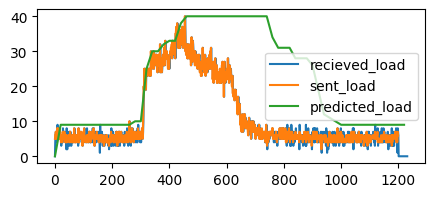

In [30]:
first_sereis = list(series_changes.keys())[
    0
]  # load should be roughly similar among the series
recieved_load = series_changes[first_sereis]["recieved_load"]
recieved_load_x = [x for x in range(0, len(recieved_load))]
predicted_load = series_changes[first_sereis]["predicted_load"]
predicted_load_x = series_changes[first_sereis]["time_interval"]
sent_load = sent_loads[first_sereis]
sent_load_x = [x for x in range(0, len(sent_loads[first_sereis]))]


plt.figure(figsize=(5, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_load, label="sent_load")
plt.plot(predicted_load_x, predicted_load, label="predicted_load")
# TODO add predicted reference load here
plt.legend()
plt.show()

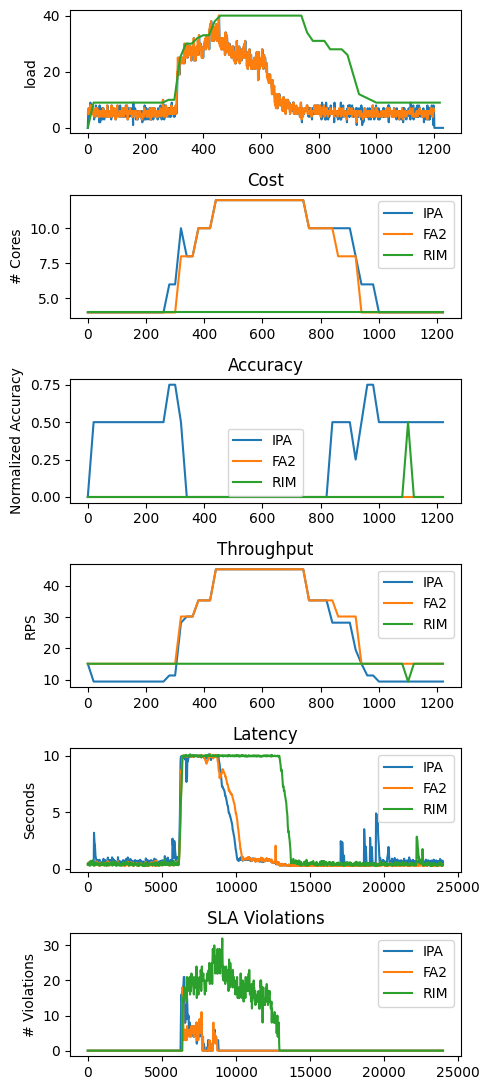

In [31]:
final_dict = {}

final_dict["load"] = {
    "sent_load": sent_load,
    "sent_load_x": sent_load_x,
    "recieved_load": recieved_load,
    "recieved_load_x": recieved_load_x,
    "predicted_load": predicted_load,
    "predicted_load_x": predicted_load_x,
}

final_dict["replica_changes"] = {}
final_dict["core_changes"] = {}
final_dict["total_core_changes"] = {}
final_dict["accuracy_changes"] = {}
final_dict["batching_changes"] = {}
final_dict["throughput_changes"] = {}
final_dict["expected_latency"] = {}
# final_dict["per_second_results"] = {}
latency_metric = "p99"  # [min, max, p99]
final_dict["measured_latency"] = {}
final_dict["change_trigger"] = {}
final_dict["objective_changes"] = {}
final_dict["timeout_dics"] = {}

for series, series_dict in series_changes.items():
    final_dict["replica_changes"][series] = {}
    final_dict["core_changes"][series] = {}
    final_dict["total_core_changes"][series] = {}
    final_dict["accuracy_changes"][series] = {}
    final_dict["batching_changes"][series] = {}
    final_dict["throughput_changes"][series] = {}
    final_dict["expected_latency"][series] = {}
    final_dict["change_trigger"][series] = {}
    final_dict["objective_changes"][series] = {}

    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["replica_changes"][series][node_name] = metrics["replicas"]
        final_dict["core_changes"][series][node_name] = metrics["cpu"]
        final_dict["accuracy_changes"][series][node_name] = metrics["accuracy"]
        final_dict["batching_changes"][series][node_name] = metrics["batch"]
        final_dict["throughput_changes"][series][node_name] = metrics["throughput"]
        final_dict["expected_latency"][series][node_name] = metrics["latency"]
    if not simulation_modes[series]:
        timeout_per_second, per_second_results = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second, per_second_results = None, None
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: latency_metric in col, per_second_results.columns)
        )
        final_dict["measured_latency"][series] = per_second_results[metric_columns]
        final_dict["measured_latency"][series] = final_dict["measured_latency"][
            series
        ].to_dict(orient="list")

    final_dict["change_trigger"][series] = loader.points_with_change(
        adaptation_log=adaptation_logs[series]
    )

    final_dict["objective_changes"][series]["objective"] = series_changes[series][
        "objective"
    ]

    if not simulation_modes[series]:
        final_dict["timeout_dics"][series] = {"timeout_per_second": timeout_per_second}

    # totals
    final_dict["replica_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["replica_changes"][series].values())
    ]
    final_dict["core_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["core_changes"][series].values())
    ]
    if accuracy_methods[series] == "sum":
        final_dict["accuracy_changes"][series]["e2e"] = [
            sum(x) for x in zip(*final_dict["accuracy_changes"][series].values())
        ]
    final_dict["throughput_changes"][series]["e2e"] = [
        min(x) for x in zip(*final_dict["throughput_changes"][series].values())
    ]
    final_dict["expected_latency"][series]["e2e"] = [
        sum(x) for x in zip(*final_dict["expected_latency"][series].values())
    ]
    final_dict["change_trigger"][series]["all"] = [
        any(x) for x in zip(*final_dict["change_trigger"][series].values())
    ]

    for key in final_dict["replica_changes"][series].keys():
        final_dict["total_core_changes"][series][key] = [
            x * y
            for x, y in zip(
                final_dict["replica_changes"][series][key],
                final_dict["core_changes"][series][key],
            )
        ]


selected_experiments = {
    "total_core_changes": {"selection": ["total"], "title": "Cost", "ylabel": "# Cores"},
    "accuracy_changes": {"selection": ["e2e"], "title": "Accuracy", "ylabel": "Normalized Accuracy"},
    "throughput_changes": {"selection": ["e2e"], "title": "Throughput", "ylabel": "RPS"},
    "measured_latency": {"selection": [f"e2e_{latency_metric}"], "title": "Latency", "ylabel": "Seconds"},
    "timeout_dics": {"selection": [f"timeout_per_second"], "title": "SLA Violations", "ylabel": "# Violations"},
}

# selected_experiments = {
#     # "total_core_changes": ["total"],
#     "batching_changes": ["yolo", "resnet-human"],
#     # "throughput_changes": ["e2e"],
#     "measured_latency": [f"e2e_{latency_metric}"],
#     "timeout_dics": [f"timeout_per_second"],
# }

# selected_experiments = {
#     "total_core_changes": ["total"],
#     "accuracy_changes": ["e2e"],
#     "throughput_changes": ["e2e"],
#     # "measured_latency": [f"e2e_{latency_metric}"],
#     # "timeout_dics": [f"timeout_per_second"],
# }

legends_rename = {}

draw_temporal_final(
    dicts_to_draw=final_dict,
    series_names=series_names,
    adaptation_interval=adaptation_intervals,
    fig_size=5,
    selected_experiments=selected_experiments,
)

# Paper ready figures

In [32]:
"""
1. Temporal could be on the showing both nodes
2. 
"""

'\n1. Temporal could be on the showing both nodes\n2. \n'